# Detecting Diabetic Retinopathy with HugsVision

This notebook illustrates the process of training a PyTorch model using HugsVision to identify diabetic retinopathy in retinal fundus images. We'll be working with a dataset of retinal fundus images labeled with diabetic retinopathy (DR) severity levels. The dataset will undergo preprocessing and augmentation to enhance the model's generalization capabilities. The model, based on the 'google/vit-base-patch16-224-in21k' architecture, will be trained using HugsVision, and its performance will be evaluated on a test set.

<div class="dataset-header-v2__top-image-container"><img src="https://storage.googleapis.com/kaggle-datasets-images/131128/312839/f2a834dc8580f0788bea087e8d3a6dbe/dataset-cover.jpeg?t=2019-03-04-05-49-08" class="Header_CoverImg-sc-1431b7d ibFJYv"></div>

### Install HugsVision

In [31]:
try:
    import hugsvision
except:
    !pip install -q hugsvision
    import hugsvision
    
print(hugsvision.__version__)

0.75.5


In [32]:
from hugsvision.dataio.VisionDataset import VisionDataset
from hugsvision.nnet.VisionClassifierTrainer import VisionClassifierTrainer
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torchvision import transforms
from PIL import Image
import torch
import os
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



## Data Preprocessing

### Image Preprocessing

Before feeding the images into the model, we need to perform preprocessing to ensure they are in a format that the model can understand. In this case, we will use the following transformations:

1. **Resize:** Resize all images to a standard size of 224x224 pixels.

2. **ToTensor:** Convert the images from PIL format to PyTorch tensors.

3. **Normalize:** Normalize the pixel values of the images to a standard range of [-1, 1].

### Data Loading and Splitting

We will use the `VisionDataset` class from HugsVision to load the retinal fundus images from the `/kaggle/input/testdataset/DR_data_cropped_classes/train` directory. The dataset will be split into training and validation sets using a test ratio of 20%.

- The `balanced=True` flag ensures that the training and validation sets are balanced with respect to the DR severity levels. This is important to prevent the model from learning to overfit to one particular severity level.

- The `augmentation=True` flag instructs the dataset to apply random augmentations to the images during training. This will help to artificially increase the size of the dataset and improve the model's generalization.

- The `transform=image_transform` argument applies the defined image preprocessing transformations to each image.

### Training and Validation Sets

The `train` and `validation` sets contain the images for training and validation, respectively. The `id2label` and `label2id` dictionaries map DR severity levels to integers and vice versa. These dictionaries are useful for converting between human-readable DR severity levels and numerical representations that the model can understand.


In [33]:
# Define image preprocessing transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load data and split into training and validation
train, validation, id2label, label2id = VisionDataset.fromImageFolder(
    "/kaggle/input/testdata12/DR_data_cropped_classes/train",
    test_ratio=0.20,  # This will now be the validation set
    balanced=True,
    augmentation=True,
    transform=image_transform,  # Apply the defined transformations
)


Split Datasets...
Balance train dataset...
The less represented label in train as 608 occurrences
Size of train after balancing is 3040
Training Dataset Elements:  2432
+---------+-----+-----+-----+-----+-----+-------+
| Dataset |  0  |  1  |  2  |  3  |  4  | Total |
+---------+-----+-----+-----+-----+-----+-------+
|  Train  | 483 | 478 | 498 | 481 | 492 | 2432  |
|  Test   | 125 | 130 | 110 | 127 | 116 |  608  |
+---------+-----+-----+-----+-----+-----+-------+


## Model Architecture

### Pre-trained Model

We will leverage the power of transfer learning by using the `google/vit-base-patch16-224-in21k` Vision Transformer (ViT) model as the base for our diabetic retinopathy detection model. This pre-trained model has several advantages:

1. **High Capacity for Learning Complex Patterns:**
   - The ViT architecture excels at capturing complex spatial relationships in images using self-attention mechanisms, making it suitable for tasks like diabetic retinopathy detection.

2. **Transferability Across Various Tasks:**
   - The pre-trained model has been trained on a large dataset with diverse visual information, enabling it to generalize well to various vision tasks, including diabetic retinopathy detection.

3. **Relatively Fast Training and Inference:**
   - ViT models are known for their parallelizable architecture, which allows for faster training and inference compared to traditional convolutional neural networks.



In [34]:
huggingface_model = 'google/vit-base-patch16-224-in21k'

## Train the Model

Now that we have selected our pre-trained model, we can proceed with building the Trainer and initiate the fine-tuning process.



In [35]:

trainer = VisionClassifierTrainer(
    model_name="MyKvasirV2Model",
    train=train,
    test=validation,  
    output_dir="./out/",
    max_epochs=10,
    batch_size=32,  # On RTX 2080 Ti
    lr=2e-5,
    fp16=True,
    model=ViTForImageClassification.from_pretrained(
        huggingface_model,
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        ignore_mismatched_sizes=True,  # Add this parameter
    ),
    feature_extractor=ViTFeatureExtractor.from_pretrained(
        huggingface_model,
    ),
)




Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'}
{'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'}
Trainer builded!
Start Training!


Epoch,Training Loss,Validation Loss
1,No log,1.306218
2,No log,1.205016
3,No log,1.181768
4,No log,1.158195
5,No log,1.142834
6,No log,1.139789
7,1.033100,1.153876
8,1.033100,1.159897
9,1.033100,1.178176
10,1.033100,1.178433


Model saved at: ./out/MYKVASIRV2MODEL/10_2024-01-12-11-56-51


## Evaluation with F1 Score

The `evaluate_f1_score()` function serves as a crucial tool for assessing the performance of a trained model on a distinct validation set. The F1 score, a widely-used metric for multi-class classification models, is employed for this evaluation. This score is determined by averaging the precision and recall scores for each class.

### Key Components of F1 Score Calculation:

1. **Precision:**
   - Precision represents the proportion of positive predictions that are genuinely correct. It gauges the accuracy of the model in identifying positive cases.

2. **Recall:**
   - Recall measures the proportion of actual positive cases that are correctly identified by the model. It assesses the model's ability to capture all positive instances.

### Advantages of F1 Score for Diabetic Retinopathy Detection:

- **Comprehensive Metric:**
  - F1 score provides a holistic assessment by considering both precision and recall, offering a balanced view of the model's performance.

- **Suitability for Imbalanced Datasets:**
  - Medical imaging datasets, including those for diabetic retinopathy, often exhibit class imbalances. F1 score is well-suited for such scenarios, ensuring a fair evaluation across different severity levels.

- **Robustness to Noise and Outliers:**
  - In the context of medical imaging data, where noise and outliers can be prevalent, F1 score proves robust, providing a reliable evaluation despite potential challenges.

### Usage of `evaluate_f1_score()` Function:

The function returns the `hyp` and `ref` variables, which contain the predicted and actual labels for the validation set. The F1 score is subsequently computed by comparing these two sets of labels. 


In [36]:
hyp, ref = trainer.evaluate_f1_score()

100%|██████████| 608/608 [00:24<00:00, 24.42it/s]

              precision    recall  f1-score   support

           0     0.5045    0.4480    0.4746       125
           1     0.4052    0.3615    0.3821       130
           2     0.3356    0.4455    0.3828       110
           3     0.6032    0.5984    0.6008       127
           4     0.6972    0.6552    0.6756       116

    accuracy                         0.5000       608
   macro avg     0.5091    0.5017    0.5032       608
weighted avg     0.5101    0.5000    0.5029       608

Logs saved at: ./out/MYKVASIRV2MODEL/10_2024-01-12-11-56-51


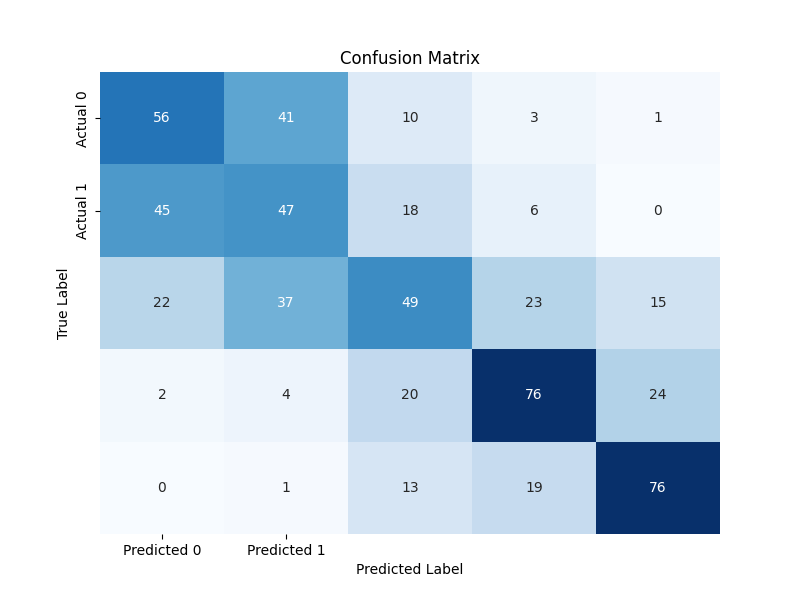

In [40]:
# Create confusion matrix
cm = confusion_matrix(ref, hyp)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Save the plot as an image
plt.savefig('/kaggle/working/confusion_matrix.png')

# Display the saved image
from IPython.display import Image
Image(filename='/kaggle/working/confusion_matrix.png')


## Loading and Evaluating the Model

### Load the saved model

The code loads the trained model (`ViTForImageClassification`) from the specified path (`model_path`) and sets it to evaluation mode, disabling training-related mechanisms.

### Define the feature extractor

The pre-trained feature extractor (`ViTFeatureExtractor`) is loaded to preprocess input images in a manner consistent with the training phase.

### Load the test dataset

Class labels are extracted from the test data directory, and a mapping between folder names and class labels is created.

### Make predictions on the test dataset

Iterating through the test dataset, the code loads, preprocesses, and sends images to the model for prediction. Predicted and true labels are stored for evaluation.

### Calculate accuracy

The accuracy is computed by comparing predicted labels with true labels, providing an overall measure of the model's performance on the test dataset.


In [41]:
import PIL.Image as Image
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Load the saved model
model_path = "/kaggle/working/out/MYKVASIRV2MODEL/10_2024-01-12-11-56-51/model"
model = ViTForImageClassification.from_pretrained(model_path)

# Set the model to evaluation mode and define the feature extractor
model.eval()
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# Define the test dataset directory and create a mapping between folder names and class labels
test_data_dir = "/kaggle/input/testdataset/DR_data_cropped_classes/test"
class_labels = sorted(os.listdir(test_data_dir))
folder_to_label = {folder: i for i, folder in enumerate(class_labels)}

# Lists to store predictions and ground truth labels
predictions, true_labels = [], []

# Iterate over folders in the test dataset
for folder in class_labels:
    image_paths = [os.path.join(test_data_dir, folder, img) for img in os.listdir(os.path.join(test_data_dir, folder))]
    
    # Iterate over images in the current folder
    for image_path in image_paths:
        image = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])(Image.open(image_path).convert("RGB"))
        inputs = feature_extractor(images=image.unsqueeze(0), return_tensors='pt', padding=True)
        outputs = model(**inputs)
        predicted_label = torch.argmax(outputs.logits, dim=1).item()

        true_label = folder_to_label[folder]
        predictions.append(predicted_label)
        true_labels.append(true_label)

# Calculate metrics
conf_matrix = confusion_matrix(true_labels, predictions)
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Confusion Matrix:
[[  0   0   0   0 100]
 [  0   0   0   0 100]
 [  0   0   0   0 100]
 [  0   0   0   0 100]
 [  0   0   0   0 100]]
Accuracy: 0.2
Precision: 0.04
Recall: 0.2
F1 Score: 0.06666666666666667


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Identifies misclassified images.
It loads the model, iterates over test images, makes predictions, and stores misclassified images. Finally, it displays the first five misclassified images.

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Image: /kaggle/input/testdataset/DR_data_cropped_classes/test/0/104_right.jpeg
Predicted label: 4
True label: 0


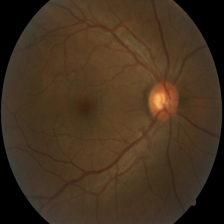

Image: /kaggle/input/testdataset/DR_data_cropped_classes/test/0/1042_right.jpeg
Predicted label: 4
True label: 0


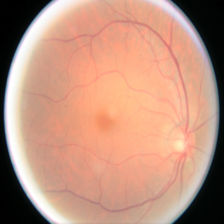

Image: /kaggle/input/testdataset/DR_data_cropped_classes/test/0/1029_left.jpeg
Predicted label: 4
True label: 0


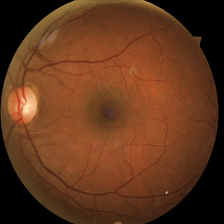

Image: /kaggle/input/testdataset/DR_data_cropped_classes/test/0/1000_right.jpeg
Predicted label: 4
True label: 0


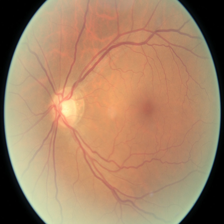

Image: /kaggle/input/testdataset/DR_data_cropped_classes/test/0/1075_right.jpeg
Predicted label: 4
True label: 0


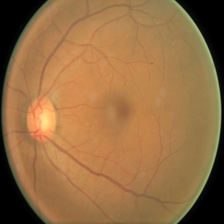

In [39]:
# Load the saved model
import matplotlib.pyplot as plt
model_path = "/kaggle/working/out/MYKVASIRV2MODEL/6_2024-01-12-11-07-03/model"
model = ViTForImageClassification.from_pretrained(model_path)

# Set the model to evaluation mode
model.eval()

# Define the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# 'test_data_dir' is the directory containing test images in subfolders
test_data_dir = "/kaggle/input/testdataset/DR_data_cropped_classes/test"
class_labels = sorted(os.listdir(test_data_dir))

# Create a mapping between folder names and class labels
folder_to_label = {folder: i for i, folder in enumerate(class_labels)}

# Lists to store predictions and ground truth labels
predictions = []
true_labels = []

misclassified_images = []

# Iterate over folders in the test dataset
for folder in class_labels:
  folder_path = os.path.join(test_data_dir, folder)
  image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path)]

  # Iterate over images in the current folder
  for image_path in image_paths:
      # Load and preprocess the image
      image = Image.open(image_path).convert("RGB")
      image = transforms.Resize((224, 224))(image)
      image = transforms.ToTensor()(image)

      # Make predictions using the model
      inputs = feature_extractor(images=image.unsqueeze(0), return_tensors='pt', padding=True)
      outputs = model(**inputs)
      logits = outputs.logits
      predicted_label = torch.argmax(logits, dim=1).item()

      # Map folder name to true label using the mapping
      true_label = folder_to_label[folder]

      # Store predictions and true labels
      predictions.append(predicted_label)
      true_labels.append(true_label)

      # Check for misclassifications
      if predicted_label != true_label:
          misclassified_images.append((image_path, predicted_label, true_label))

# Select five misclassified images
misclassified_images = misclassified_images[:5]


    
from IPython.display import display

# Iterate over misclassified images
for image_path, predicted_label, true_label in misclassified_images:
    # Load and resize the image
    image = Image.open(image_path)
    resized_image = image.resize((224, 224))  # Adjust the size as needed

    # Display the image
    print(f"Image: {image_path}")
    print(f"Predicted label: {predicted_label}")
    print(f"True label: {true_label}")

    # Display the resized image using IPython.display
    display(resized_image)
